# PREPROCESSING

This notebook contains the process to compile datasets for modeling purpose.

#### The main steps of the process:

- Reading in stock price datasets, resturcturing and creating price based labels

- Reading in article headlines, stemming and tokenizing the text

- Merging and concatenate the article headlines and lables

- Split into train and test dataset

- Saving into a csv file


In order to compare the company's performance I used <b>S&P500</b> index.

## Importing the necessary libraries

In [50]:
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot
%matplotlib inline

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_row', 1000)

## 1. Preprocessing the stock price datasets

### 1.1. Importing the dataset 

#### Source: https://finance.yahoo.com

In [51]:
companies = ['tesla', 'ford', 'ibm', 'goldman', 'boeing', 'ge']

In [52]:
sp500 = pd.read_csv('financial/SP500.csv')

tesla_stock = pd.read_csv('financial/TSLA.csv')
ford_stock = pd.read_csv('financial/F.csv')
ibm_stock = pd.read_csv('financial/IBM.csv')
goldman_stock = pd.read_csv('financial/GS.csv')
boeing_stock = pd.read_csv('financial/BA.csv')
ge_stock = pd.read_csv('financial/GE.csv')
jpm_stock = pd.read_csv('financial/JPM.csv')
microsoft_stock = pd.read_csv('financial/MSFT.csv')

### 1.2. Restructuring/labeling stock data

#### Labeling rule:
* <b>good</b>: if the company share price performed better than the index
* <b>bad</b>: if the company share price performed worse than the index

Calculation:
* For calculating changes in stock prices 'Close' prices are used
* 'change': % change compared to the previous day
* 'nextday': % change of the following day

In [143]:
def price_ratios(stock_data, index_data):
    '''
    This function returns a restructured dataframe for labeling purpose.

    The function requires specific structure of the data, which is based on the current 
    datascource (yahoo/finance).

    -------------------------
    Inputs:
        stock_data: dataframe
        index_data: dataframe

    -------------------------
    Returns: dataframe

    '''
    # merge dataframes
    df = pd.merge(stock_data, index_data, how='inner',
                  on='Date', suffixes=('', '_i'))
    
    df.columns = df.columns.str.lower()
    df = df[['date','close', 'close_i', 'volume']]
    
    # shifting prices by one day ahead and merge
    df = df.set_index('date')
    shifted_next = df.shift(periods=-1)
    df = pd.merge(df, shifted_next, on='date', suffixes=('', '_next')) #next day prices
    df = df.reset_index()
     
    # shifting prices by one day back and merge
    df = df.set_index('date')
    shifted_prev = df.shift(periods=1)
    df = pd.merge(df, shifted_prev, on='date', suffixes=('', '_prev')) #previous day prices
    df = df.reset_index()

    # calculate rolling means for the volume
    df['volume_avg'] = df.volume.rolling(window=14).mean().fillna(method='backfill')
    df['volume_ratio'] = round(df.volume / df.volume_avg, 2)
    
    # creating ratios
    df['change'] = round(df['close'] / df['close_prev'] * 100 - 100, 4)
    df['nextday'] = round(df['close_next'] / df['close'] * 100 - 100, 4)
    df['change_i'] = round(df['close_i'] / df['close_i_prev'] * 100 - 100, 4)
    df['nextday_i'] = round(df['close_i_next'] / df['close_i'] * 100 - 100, 4)

    # adding trading holidays to the dataframe and fill
    dates = []
    last_day = pd.to_datetime(stock_data.iloc[-1, 0], format='%Y-%m-%d')
    for i in range(3615):
        date = last_day - datetime.timedelta(days=i)
        date = date.strftime('%Y-%m-%d')
        dates.append(date)
    date_df = pd.DataFrame(dates, columns=['date'])
    date_df = date_df.sort_values(by='date')
    df = pd.merge(date_df, df, on='date', how='left')

    # fill in trading holidays with the next valid data
    df = df.fillna(method='backfill')
    
    df = df[['date', 
             'change', 'nextday', 'change_i', 'nextday_i', 
             'volume_ratio']]
    
    return df

In [5]:
def label(df):
    df.loc[df['change'] > df['change_i'] + 0.5, 'label'] = 2

    df.loc[df['change'] < df['change_i'] - 0.5, 'label'] = 3

    df.loc[df.label.isna(), 'label'] = 1
    
    df = df[['date', 'label']]
    
    return df

In [6]:
def label(df):
    df.loc[(df['change'] > df['change_i'])&(df['nextday'] > df['nextday_i']), 'label'] = 1

    df.loc[(df['change'] < df['change_i'])&(df['nextday'] < df['nextday_i']), 'label'] = 0

    df.loc[df.label.isna(), 'label'] = 999
    
    df = df[['date', 'label']]
    
    return df

In [4]:
# Labeling method 3: this labeling takes into consideration the volume and the relative change

def label(df):
    df.loc[(df['change'] > df['change_i'] + 0.5)&(df['volume_ratio'] > 1), 'label'] = 1

    df.loc[(df['change'] < df['change_i'] - 0.5)&(df['volume_ratio'] > 1), 'label'] = 0

    df.loc[df.label.isna(), 'label'] = 999
    
    return df

In [8]:
# Labeling method 4
def label(df):
    df.loc[(df['change'] > df['change_i'] + 1)&(df['volume_ratio'] > 0.9), 'label'] = 1

    df.loc[(df['change'] < df['change_i'] - 1)&(df['volume_ratio'] > 0.9), 'label'] = 0

    df.loc[df.label.isna(), 'label'] = 999
    
    return df

In [144]:
# Labeling method 5
def label(df):
    df.loc[(df['change'] > df['change_i'] + 1)&(df['volume_ratio'] > 1), 'label'] = 1

    df.loc[(df['change'] < df['change_i'] - 1)&(df['volume_ratio'] > 1), 'label'] = 0

    df.loc[df.label.isna(), 'label'] = 999
    
    return df

In [145]:
tesla_label = label(price_ratios(tesla_stock, sp500))
ford_label = label(price_ratios(ford_stock, sp500))
ibm_label = label(price_ratios(ibm_stock, sp500))
goldman_label = label(price_ratios(goldman_stock, sp500))
boeing_label = label(price_ratios(boeing_stock, sp500))
ge_label = label(price_ratios(ge_stock, sp500))
jpm_label = label(price_ratios(jpm_stock, sp500))
microsoft_label = label(price_ratios(microsoft_stock, sp500))

In [72]:
labels = {1: 'good', 999: 'neutral', 0: 'bad'}
microsoft_label.label.value_counts()

999.0    3279
1.0      176 
0.0      160 
Name: label, dtype: int64

## 2. Preprocessing the article information

### 2.1. Import headlines

In [57]:
import pymongo

myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
news = myclient['news']

In [102]:
tesla_news = pd.DataFrame.from_records(news.tesla_news.find())
ford_news = pd.DataFrame.from_records(news.ford_news.find())
ibm_news = pd.DataFrame.from_records(news.ibm_news.find())
goldman_news = pd.DataFrame.from_records(news.goldman_news.find())
boeing_news = pd.DataFrame.from_records(news.boeing_news.find())
ge_news = pd.DataFrame.from_records(news.ge_news.find())
jpmorgan_news = pd.DataFrame.from_records(news.jpmorgan_news.find())
microsoft_news = pd.DataFrame.from_records(news.microsoft_news.find())

### 2.2. Concatenate headline and summary into one text

In [103]:
def concat_news(some_news):
    some_news['text'] = some_news.headline +' '+ some_news.summary
    some_news = some_news[['date', 'text', 'topic']]
    return some_news

In [104]:
tesla_news = concat_news(tesla_news)
ford_news = concat_news(ford_news)
ibm_news = concat_news(ibm_news)
goldman_news = concat_news(goldman_news)
boeing_news = concat_news(boeing_news)
ge_news = concat_news(ge_news)
jpmorgan_news = concat_news(jpmorgan_news)
microsoft_news = concat_news(microsoft_news)

### 2.3. Keeping just the relevant articles

Relevant a headline or the summary, if it contains the company name (as a keyword), and its topic is one of the relevant topics (see below the list).

In [105]:
relevant_topics = ['BUSINESS', 'TECH', 'EARNINGS', 'nan', 'MARKETS', 'HEARD ON THE STREET', 'AUTOS'
                  ,'EUROPE', 'AUTOS - INDUSTRY', 'ASIAN BUSINESS NEWS']

def relevant_topic(topic):
    if topic in relevant_topics:
        return True
    return False

def relevant_company(text, keywords):
    '''
    Inputs:
        text: string
        keywords: list of string objects
    Returns:
        boolean
    '''
    for keyword in keywords:
        if keyword in text:
            return True
    return False

def relevant_rows(df, keywords):
    '''
    Returns the rows of the dataframe, where the text is relevant
    Input:
        df: dataframe
        keywords: list of string objects
    Returns:
        dataframe with the relevant rows
    '''
    df = df.loc[df.text.apply(lambda x: relevant_company(x, keywords))]
    df = df.loc[df.topic.apply(lambda x: relevant_topic(x))]
    df = df.loc[df.text.apply(lambda x: 'expected to trade actively' not in x)]
    
    print('Number of rows: ',len(df))
    return df

In [106]:
tesla_news = relevant_rows(tesla_news, ['Tesla'])
ford_news = relevant_rows(ford_news, ['Ford'])
ibm_news = relevant_rows(ibm_news, ['IBM', 'International Business Machines'])
goldman_news = relevant_rows(goldman_news, ['Goldman'])
boeing_news = relevant_rows(boeing_news, ['Boeing'])
ge_news = relevant_rows(ge_news, ['GE', 'General Electric'])
jpmorgan_news = relevant_rows(jpmorgan_news, ['JPMorgan'])
microsoft_news = relevant_rows(microsoft_news, ['Microsoft'])

Number of rows:  726
Number of rows:  942
Number of rows:  354
Number of rows:  1168
Number of rows:  1323
Number of rows:  816
Number of rows:  170
Number of rows:  1000


### 2.4. Converting dates 

If the article is published after the closing time of the stock market, I convert its date into the next day, becaues this article can affect only the next day price. 

In [107]:
def converting_date(some_date):
    # compares the published time of the article with the closure of the stockmarket
    # if the article is published after the closure, it's date changed to the next day
    if pd.to_datetime(some_date).time() > datetime.time(16, 0):
        day = pd.to_datetime(some_date).date() + datetime.timedelta(days=1)
    else:
        day = pd.to_datetime(some_date).date()
    return day.strftime('%Y-%m-%d')

In [108]:
tesla_news.date = tesla_news.date.apply(converting_date)
ford_news.date = ford_news.date.apply(converting_date)
ibm_news.date = ibm_news.date.apply(converting_date)
microsoft_news.date = microsoft_news.date.apply(converting_date)
goldman_news.date = goldman_news.date.apply(converting_date)
jpmorgan_news.date = jpmorgan_news.date.apply(converting_date)
boeing_news.date = boeing_news.date.apply(converting_date)
ge_news.date = ge_news.date.apply(converting_date)

### 2.5. Stemming/tokenizing

The 'stopwords' and 'negativewords' were originally based on the stopwords of nltk library. For this sentiment
analysis I reviewed and modified the content of stopwords (removed keywords, added some not predicting words).
Words that change completely the meaning of the following words (I call them like 'negative words') will be replaced simply with 'not'.

In [109]:
my_stopwords = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an',
                'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being',
                'between', 'both', 'but', 'by', 'can', 'd', 'did', 'do', 'does', 'doing',
                'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have',
                'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his',
                'how', 'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its', 'itself', 'just',
                'll', 'm', 'ma', 'me', 'might', 'more', 'most', 'my', 'myself', 'neeed',
                'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours',
                'ourselves', 'over', 'own', 're', 's', 'u', 't', 'same', 'she',
                "she's", 'should', "should've", 'so', 'some', 'such', 'than', 'that', "that'll",
                'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these',
                'they', 'this', 'k', 'those', 'through', 'to', 'too', 'until', 've', 'very',
                'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
                'why', 'will', 'with', 'would', 'could', 'y', 'you', "you'd", "you'll",
                "you're", "you've", 'your', 'yours', 'yourself', 'yourselves', 'mr', 'mrs',
                'ms', 'nan', 'inc', 'co', 'com', 'wsj', 'monday', 'tuesday', 'wednesday',
                'thursday', 'friday', 'saturday', 'sunday', 'either', 'shall', 'must', 'with',
                'without', 'may', 'whose', 'yet', 'another']

my_negativewords = ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn',
                    'mightn', 'no', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren',
                    'won', 'wouldn', 'neither', 'nor']

stems = {'reveals': 'reveal', 'revealed': 'reveal', 'expanding': 'expand', 'seen': 'see', 'boosting': 'boost',
         'delivery': 'deliver', 'delivered': 'deliver', 'safer': 'safe', 'posted': 'post', 'declining': 'decline',
         'raising': 'raise', 'lower': 'low', 'declined': 'decline', 'recalling': 'recall', 'older': 'old',
         'approval': 'approve', 'coming': 'come', 'selection': 'select', 'powered': 'power', 'lofty': 'loft',
         'earnings': 'earning', 'stepping': 'step', 'announced': 'announce', 'replacement': 'replace',
         'ended': 'end', 'boosted': 'boost', 'climbed':'climb', 'warning': 'warn', 'allowing':'allow',
         'quarterly': 'quarter', 'coming': 'come', 'exceeding': 'exceed', 'gave': 'give', 'named': 'name',
         'announcing': 'announce', 'worries': 'worry', 'worried': 'worry', 'aggressively':'aggressive',
         'smallest': 'small', 'offering': 'offer', 'disappoints': 'disappoint', 'reported': 'report',
         'lowest': 'low', 'continues':'continue', 'gaming': 'game', 'teaming':'team', 'approved':'approve',
         'putting': 'put', 'prepares': 'prepare', 'preparing': 'prepare', 'longest': 'long', 'filing':'file',
         'decliners': 'decline', 'winning': 'win', 'asian': 'asia', 'artificially':'artificial', 
         'intensified': 'intense', 'bought': 'buy', 'involved': 'involve', 'agreed': 'agree', 'filed':'file',
         'resolved': 'resolve', 'appeared':'appear', 'appointed':'appoint', 'appoints':'appoint',
         'loses': 'lose', 'fell': 'fall', 'falling': 'fall', 'beating': 'beat', 'expectation': 'expect',
         'expected': 'expect', 'disappointed': 'disappoint', 'disappointing':'disappoint', 'feared':'fear',
         'relieving': 'relieve', 'deliveries': 'deliver', 'debated': 'debate', 'dropped': 'drop',
         'losing': 'lose', 'became': 'become','awarded':'award', 'attempting':'attempt', 'faster':'fast',
         'decided': 'decide', 'violated': 'violate', 'warns': 'warn', 'tumbled': 'tumble', 'facing': 'face',
         'grounded': 'ground', 'cleared': 'clear', 'rose': 'rise', 'analysts': 'analyst', 'failing':'fail',
         'highest': 'high', 'slowing': 'slow', 'accused':'accuse', 'accuses':'accuse', 'acquired':'acquired',
         'acquires':'acquire','acquiring':'acquire', 'added':'add', 'adding':'add', 'allegation':'allege',
         'alleged':'allege','alleging':'allege', 'benefited': 'benefit', 'bidder':'bid', 'bidding':'bid',
         'came':'come', 'challenged':'challenge', 'challenging':'challenge', 'changing':'change',
         'broadens':'broad','broaden':'broad', 'broader':'broad', 'built':'build','buying':'buy', 'called':'call',
         'charged':'charge', 'collaborating':'collaborate', 'collaboration':'collaborate','competitor':'compete',
         'competitive':'compete', 'competition':'compete', 'considered':'consider', 'continued':'continue',
         'continuing':'continue', 'copying':'copy', 'corporation':'corporate', 'created':'create',
         'creating':'create', 'criticism':'critical','currently':'current', 'cutting':'cut', 'decision':'decide',
         'creation':'create', 'deepen':'deep', 'deeper':'deep', 'defended':'defend', 'expects':'expect',
         'defends':'defend', 'designed':'design', 'developed':'develop', 'developer':'develop', 'failed':'fail',
         'defense':'defend','developing':'develop', 'development':'develop', 'develops':'develop',
         'developed':'develop', 'dismissed':'dismiss', 'driver':'drive', 'driving':'drive', 'easier':'easy', 
         'gainer':'gain', 'given':'give', 'giving':'give', 'granting':'grant', 'growing':'grow', 'grown':'grow',
         'grows':'grow', 'harder':'hard', 'higher':'high', 'held':'hold', 'hired':'hire', 'hiring':'hire', 
         'holding':'hold',  'included':'inclued', 'includes':'include','including':'include', 
         'increased':'increase','increasing':'increase','increasingly':'increase','introduced':'introduce',
         'introducing':'introduce', 'investigating':'investigate','investigation':'investigate',
         'involving':'involve', 'joined':'join', 'largely':'large', 'larger':'large', 'largest':'large',
         'joining':'join', 'jumped':'jump', 'keeping':'keep', 'known':'know', 'lagging':'lag',
         'launched':'launch', 'launching':'launch', 'learning':'learn', 'lifted':'lift','lobbying':'lobby',
         'longer':'long', 'looking':'look', 'made':'make', 'making':'make','managed':'manage', 
         'managing':'manage',
         'moved':'move', 'officially':'official', 'opened':'open', 'opening':'open',  'owned':'own',
         'owner':'own', 'participating':'participate', 'participation':'participate', 'paying':'pay', 
         'owns':'own','paid':'pay', 'performance':'perform', 'performing':'perform', 'picked':'pick', 
         'picking':'pick', 'pleged':'pledge', 'popularity':'popular','potentially':'potential',
         'previously':'previous', 'promotion':'promote', 'promotes':'promote','proposal':'propose',
         'proposed':'propose','provided':'provide', 'provider':'provide','provides':'provide',
         'providing':'provide','publicly':'public','pulled':'pull', 'rapidly':'rapid','reached':'reach',
         'pulling':'pull','pushed':'push','raised':'raise','reaching':'reach','received':'receive',
         'pushing':'push','recently':'recent','reduced':'reduce', 'regulation':'regulate', 'released':'release',
         'relies':'rely', 'remains':'remain', 'requested':'request', 'resigned':'resign', 'retired':'retire',
         'retirement':'retire', 'revealing':'reveal', 'returned':'return', 'showing':'show', 'signed':'sign',
         'returning':'return','running':'run', 'said':'say', 'selling':'sell', 'showed':'show',
         'smaller':'small', 'started':'start', 'starting':'start', 'threatens':'threat', 'targeted':'target', 
         'taken':'take', 'tackling':'tackle', 'sued':'sue', 'struggled':'struggle', 'tried':'try', 
         'struggling':'struggle','stronger':'strong', 'strategic':'strategy', 'stored':'store',
         'troubled':'trouble', 'trying':'try', 'turning':'turn','unveiled':'unveil', 'unveils':'unveil',
         'using':'use', 'violation':'violate', 'weaving':'weave', 'weaker':'weak', 'weakness':'weak', 
         'weaken':'weak', 'watched':'watch', 'watching':'watch', 'warned':'warn', 'welcomed':'welcome',
         'wider':'wide', 'working':'work'
        }


In [119]:
import re
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()


def my_tokenizer(text):
    # just keep the words (remove characters and numbers)
    token_list = re.findall(r'([a-zA-Z]+)', text)

    # lowercase
    token_list = [t.lower() for t in token_list]

    # remove stopwords
    token_list = [word for word in token_list if word not in my_stopwords]

    # replace negative words to 'not'
    for i, word in enumerate(token_list):
        if word in my_negativewords:
            token_list[i] = 'not'
    
    # lemmatize
    token_list = [wnl.lemmatize(word) for word in token_list]
    
    # use the stems dictionary
    token_list = [stems.get(word, word) for word in token_list]
    
    # converting list into text
    token_text = ' '.join(token_list)

    return token_text

In [120]:
tesla_news['tokens'] = tesla_news.text.apply(my_tokenizer)
ford_news['tokens'] = ford_news.text.apply(my_tokenizer)
ibm_news['tokens'] = ibm_news.text.apply(my_tokenizer)
goldman_news['tokens'] = goldman_news.text.apply(my_tokenizer)
boeing_news['tokens'] = boeing_news.text.apply(my_tokenizer)
ge_news['tokens'] = ge_news.text.apply(my_tokenizer)
jpmorgan_news['tokens'] = jpmorgan_news.text.apply(my_tokenizer)
microsoft_news['tokens'] = microsoft_news.text.apply(my_tokenizer)

## 3. Merging/concatenating

In [146]:
tesla = pd.merge(tesla_news, tesla_label, how='left', on='date')
ford = pd.merge(ford_news, ford_label, how='left', on='date')
ibm = pd.merge(ibm_news, ibm_label, how='left', on='date')
goldman = pd.merge(goldman_news, goldman_label, how='left', on='date')
boeing = pd.merge(boeing_news, boeing_label, how='left', on='date')
ge = pd.merge(ge_news, ge_label, how='left', on='date')
jpm = pd.merge(jpmorgan_news, jpm_label, how='left', on='date')
microsoft = pd.merge(microsoft_news, microsoft_label, how='left', on='date')

In [147]:
data = pd.concat([tesla, ford, ibm, goldman, boeing, ge, jpm, microsoft])

In [148]:
data = data.loc[data.tokens.apply(lambda x: 'stock defined week' not in x)]

### 3.2. Removing not polarizing articles

In [149]:
data.label.value_counts()

999.0    4733
1.0      887 
0.0      879 
Name: label, dtype: int64

In [150]:
data = data.loc[data.label != 999]
data = data.reset_index()
data.drop(columns = 'index', inplace=True)

In [151]:
data.shape

(1766, 10)

## 4. Train-test split / save into a csv file

#### Train test selection by random chance, label5

In [152]:
from sklearn.model_selection import train_test_split

data_train5, data_test5 = train_test_split(data,
                                           test_size=.20,
                                           random_state=10,
                                           stratify=data.label)

In [153]:
data_train5.to_csv('train5.csv')
data_test5.to_csv('test5.csv')

In [154]:
data_train5.label.value_counts()

1.0    709
0.0    703
Name: label, dtype: int64

In [155]:
data_test5.label.value_counts()

1.0    178
0.0    176
Name: label, dtype: int64

#### Test data is selected by date (the last year):

In [41]:
data_test2 = data.loc[data.date.str[:4]=='2019']
data_train2 = data.loc[data.date.str[:4]!='2019']

In [42]:
data_train2.to_csv('train2.csv')
data_test2.to_csv('test2.csv')

In [43]:
data_train2.label.value_counts()

0.0    1192
1.0    1168
Name: label, dtype: int64

In [44]:
data_test2.label.value_counts()

0.0    156
1.0    137
Name: label, dtype: int64

#### Labeling method 4, with random chance:

In [46]:
from sklearn.model_selection import train_test_split

data_train1, data_test1 = train_test_split(data,
                                           test_size=.20,
                                           random_state=10,
                                           stratify=data.label)

data_train1.to_csv('train3.csv')
data_test1.to_csv('test3.csv')

## 5. Visualisations

In [160]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(['Mr.', 'Mrs.', 'Ford', 'Tesla', 'Boeing', 'Microsoft', 'Goldman', 'Sachs', 'GE',
                 'General', 'Electric', 'said', 'will', 'company', 'IBM', 'Motor', 'year', 'car'])
def plot_wordcloud(text):
    plt.figure(figsize=(8,6))
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap='tab10',
                          max_words=50, width= 400, height=300).generate(neg_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#colormaps: 'tab10'


In [161]:
neg_text = " ".join(review for review in data.loc[data.label==0].text)
pos_text = " ".join(review for review in data.loc[data.label==1].text)

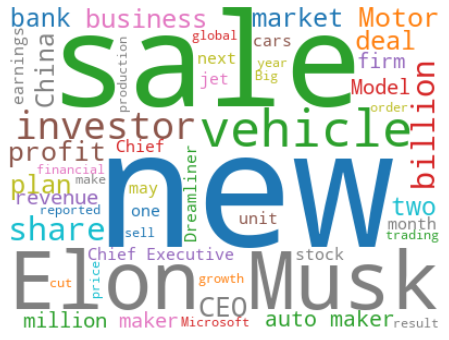

In [162]:
plot_wordcloud(neg_text)

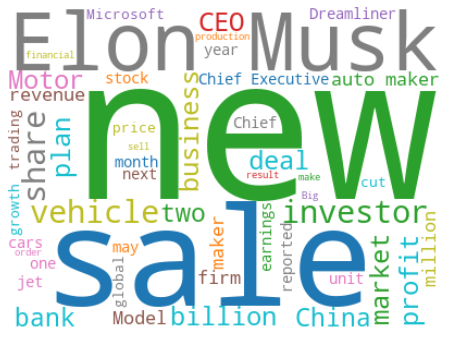

In [163]:
plot_wordcloud(pos_text)

In [165]:
stopwords

{'Boeing',
 'Electric',
 'Ford',
 'GE',
 'General',
 'Goldman',
 'IBM',
 'Microsoft',
 'Motor',
 'Mr.',
 'Mrs.',
 'Sachs',
 'Tesla',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'car',
 'com',
 'company',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',